# MNIST手写字符体识别

本指南将训练一个神经网络模型，对MNIST图像进行分类，详细内容会在实际操作的同时进行介绍。

本指南使用了 [tf.keras](https://tensorflow.google.cn/guide/keras)，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [2]:
# TensorFlow and tf.keras
# conda install -c conda-forge tensorflow 安装 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-02-23 14:41:28.656798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


## 导入 MNIST 数据集

经典 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据集，常被用作计算机视觉机器学习程序的“Hello, World”。MNIST 数据集包含手写数字（0、1、2 等）的图。数据集都相对较小，都用于验证某个算法是否按预期工作。对于代码的测试和调试，是很好的起点。

在本指南中，我们使用 60,000 张图像来训练网络，使用 10,000 张图像来评估网络学习对图像进行分类的准确程度。可以直接从tf.keras.datasets.mnist 中导入和加载 MNIST 数据，原始的4个idx文件打包为一个npz文件。下载地址因网络问题无法访问，所以直接读取实验包中的npz文件。

In [3]:
!mkdir -p ~/.keras/datasets
!cp mnist.npz ~/.keras/datasets

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # path='mnist.npz', relative to ~/.keras/datasets

# path="./mnist.npz"
# with np.load(path, allow_pickle=True) as f:
#     train_images, train_labels = f['x_train'], f['y_train']
#     test_images, test_labels = f['x_test'], f['y_test']

train_images = tf.expand_dims(train_images, axis=3, name=None)
test_images = tf.expand_dims(test_images, axis=3, name=None)

2023-02-23 14:41:38.115342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 14:41:38.181569: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


加载数据集会返回四个 NumPy 数组：

- `train_images` 和 `train_labels` 数组是*训练集*，即模型用于学习的数据。
- `test_images` 和 `test_labels` 数组是*测试集*，会被用来对模型进行测试。

图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。*标签*是整数数组，介于 0 到 9 之间。

每个图像都会被映射到一个标签。由于数据集不包括*类名称*，请将它们存储在下方，供稍后绘制图像时使用：

In [5]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## 浏览数据

在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [6]:
train_images.shape

TensorShape([60000, 28, 28, 1])

同样，训练集中有 60,000 个标签：

In [7]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [8]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [9]:
test_images.shape

TensorShape([10000, 28, 28, 1])

测试集包含 10,000 个图像标签：

In [10]:
len(test_labels)

10000

## 预处理数据

在训练网络之前，可以对数据进行预处理。原始的mnist像素值处于 0 到 255 之间：

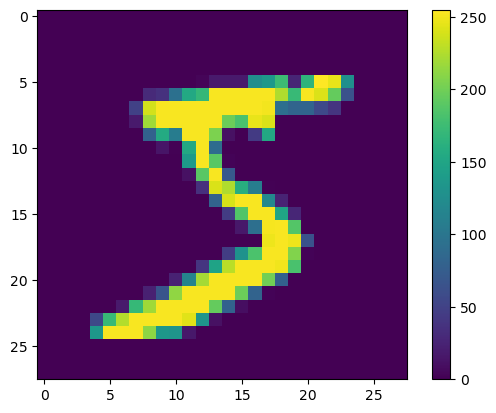

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
# 也可以将取值归一化0-1
#train_images = train_images / 255

#test_images = test_images / 255

train_images = tf.cast(train_images, tf.float32)
test_images = tf.cast(test_images, tf.float32)

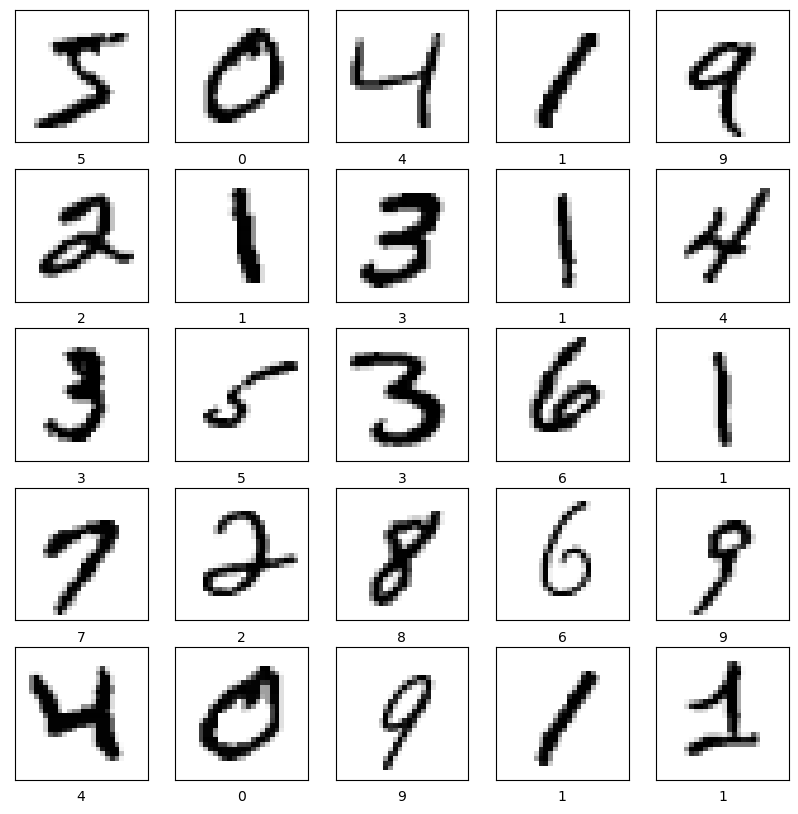

In [13]:
# 为了验证数据的格式是否正确，以及是否已准备好构建和训练网络，显示*训练集*中的前 25 个图像，并在每个图像下方显示类名称。
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 构建模型

构建神经网络需要先配置模型的层，然后再编译模型。

### 设置层

神经网络的基本组成部分是<em>层</em>。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。

大多数深度学习都包括将简单的层链接在一起。大多数层（如 `tf.keras.layers.Dense`）都具有在训练期间才会学习的参数。

In [14]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='relu'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(10)])

该网络的第一层 `tf.keras.layers.Flatten` 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 `tf.keras.layers.Dense` 层的序列。它们是密集连接或全连接神经层。第一个 `Dense` 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

### 编译模型

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的<em>编译</em>步骤中添加的：

- <em>损失函数</em> - 测量模型在训练期间的准确程度。你希望最小化此函数，以便将模型“引导”到正确的方向上。
- <em>优化器</em> - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
- <em>指标</em> - 用于监控训练和测试步骤。以下示例使用了*准确率*，即被正确分类的图像的比率。

In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 训练模型

训练神经网络模型需要执行以下步骤：

1. 将训练数据馈送给模型。在本例中，训练数据位于 `train_images` 和 `train_labels` 数组中。
2. 模型学习将图像和标签关联起来。
3. 要求模型对测试集（在本例中为 `test_images` 数组）进行预测。
4. 验证预测是否与 `test_labels` 数组中的标签相匹配。


### 向模型馈送数据

要开始训练，请调用 <code>model.fit</code> 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [16]:
model.fit(train_images, train_labels, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 61s 32ms/step - loss: 0.4004 - accuracy: 0.8803
Epoch 2/2
1875/1875 [==============================] - 54s 29ms/step - loss: 0.1193 - accuracy: 0.9635


在模型训练期间，会显示损失和准确率指标。

### 评估准确率

接下来，比较模型在测试数据集上的表现：

In [19]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0874 - accuracy: 0.9713 - 695ms/epoch - 2ms/step

Test accuracy: 0.9713000059127808


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表*过拟合*。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。有关更多信息，请参阅以下内容：

- [演示过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [防止过拟合的策略](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### 进行预测

模型经过训练后，您可以使用它对一些图像进行预测。

In [20]:
probability_model = model         

In [21]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [22]:
predictions[0]

array([ -4.0429196 ,   0.22500418,   4.2739005 ,   4.8873405 ,
         0.05628142,  -3.1129913 , -12.509938  ,  22.180346  ,
        -0.3509208 ,   6.152817  ], dtype=float32)

预测结果是一个包含 10 个数字的数组，其中数值最大的为最终的识别结果。

In [23]:
np.argmax(predictions[0])

test_labels[0]

7

您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [24]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),   # 因为没归一化，所以该值非概率值
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 验证预测结果

在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

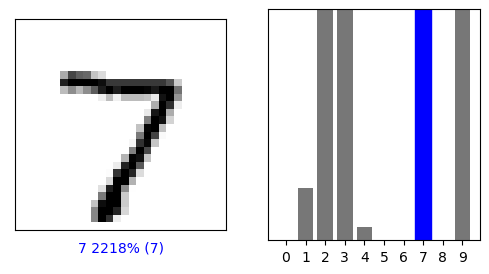

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

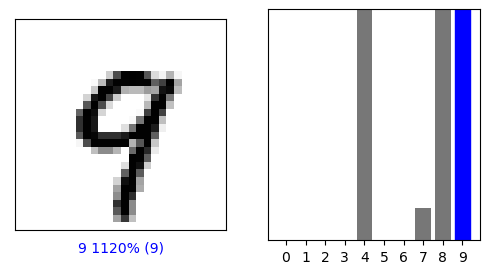

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

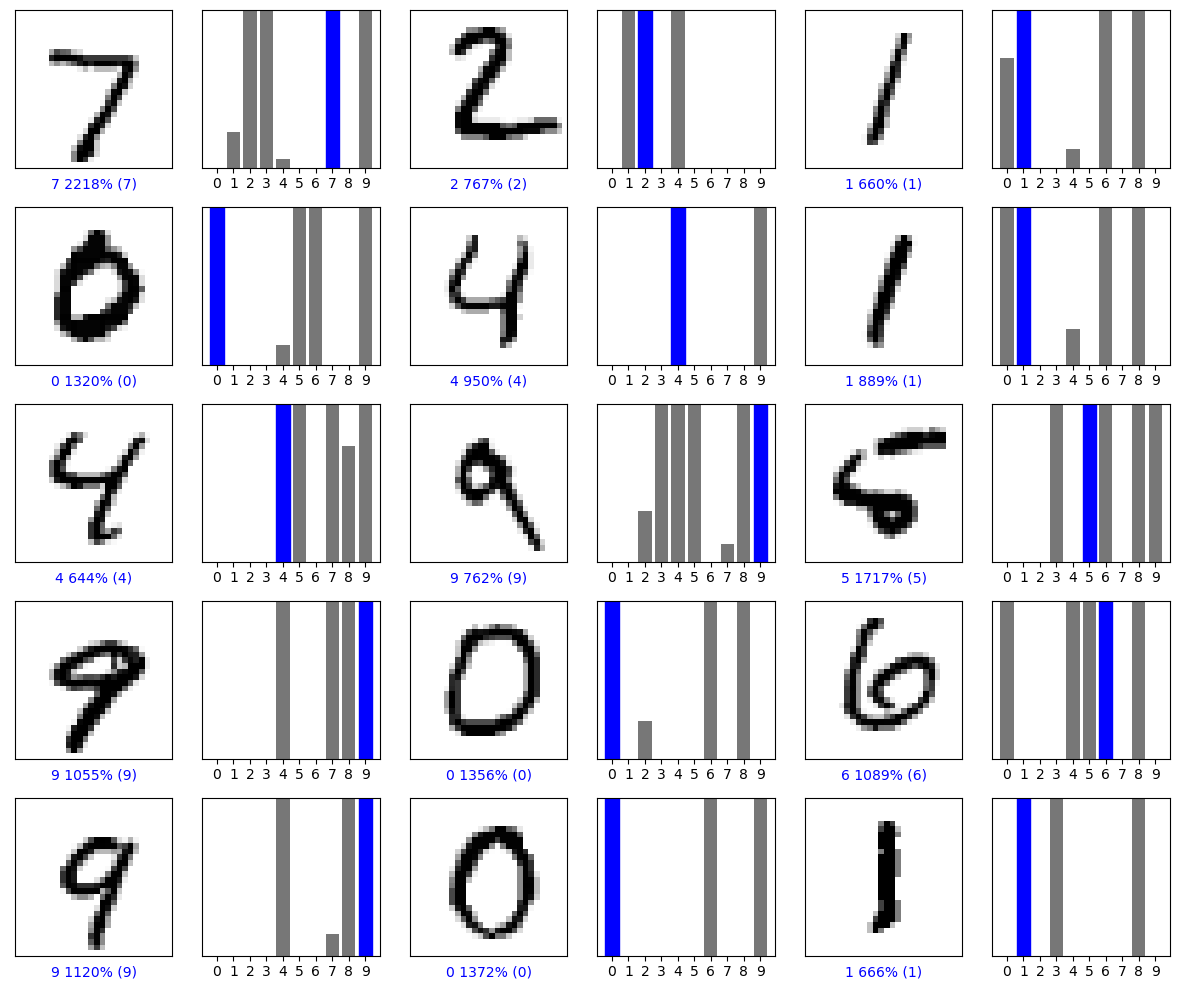

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 使用训练好的模型

最后，使用训练好的模型对单个图像进行预测。

In [28]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28, 1)


`tf.keras` 模型经过了优化，可同时对一个*批*或一组样本进行预测。因此，即便您只使用一个图像，您也需要将其添加到列表中：

In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28, 1)


现在预测这个图像的正确标签：

In [30]:
predictions_single = probability_model.predict(img)

unnorm_result = predictions_single
#@TODO，要求unnorm_result中的数据归一化

1/1 [==============================] - 0s 19ms/step


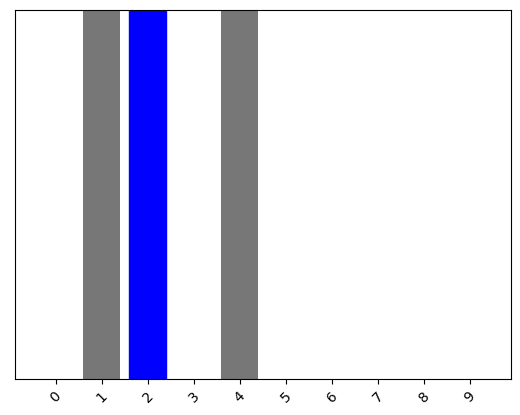

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`keras.Model.predict` 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [32]:
np.argmax(predictions_single[0])

2

该模型会按照预期预测标签。

主要参考：

https://www.tensorflow.org/tutorials/keras/classification?hl=zh-cn

https://medium.com/analytics-vidhya/lenet-with-tensorflow-a35da0d503df

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.